# Importing Libraries

In [17]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset


from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

from torch_geometric.nn import GCNConv
from torch_geometric.transforms import Constant
from sklearn.utils import check_random_state

from scipy.spatial import distance
import seaborn as sns

import json
import pickle
import random

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

bad_files_indexes = []
bad_files_path = 'bad' + '/' + 'badindexes.lt'

In [18]:
# Set random seed for NumPy
np.random.seed(42)


# Set random seed for scikit-learn
random_state = check_random_state(42)

In [19]:
Memo = {}
#Loading the CSV file
df = pd.read_csv('metadata_modelnet10.csv')
df = df.to_numpy()

def save_memo(memo, filename = 'records.dat'):
    with open(filename, 'wb') as f:
        pickle.dump(memo, f)

def load_memo(filename = 'records.dat'):
    try:
        with open(filename, 'rb') as f:
            memo = pickle.load(f)
            return memo
    except FileNotFoundError:
        print("Memo file not found. Returning an empty dictionary.")
        return {}
    
def numbers_to_string(numbers):
    """
    Convert a list of numbers into a string.

    Args:
    - numbers (list): A list of numbers.

    Returns:
    - result_string (str): A string containing the numbers concatenated together.
    """
    # Convert numbers to strings
    number_strings = map(str, numbers)
    
    # Join the strings into a single string
    result_string = "".join(number_strings)
    
    return result_string

def save_list(data, filename):
    """
    Save a list of lists to a file using pickle.

    Args:
    - data (list): The list of lists to be saved.
    - filename (str): The name of the file to save the data to.
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_list(filename):
    """
    Load a list of lists from a file using pickle.

    Args:
    - filename (str): The name of the file to load the data from.

    Returns:
    - data (list): The loaded list of lists.
    """
    if not os.path.exists(filename):
        return []
    
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [20]:
Memo = load_memo()
bad_files_indexes = load_list(bad_files_path)
print(bad_files_indexes)

Memo file not found. Returning an empty dictionary.
[]


# 3D Points to Graphs

In [21]:
#Read off files
def read_off_file(file_path): 
    with open(file_path, 'r') as file:
        lines = file.readlines()

    vertex_count, face_count, _ = map(int, lines[1].split())
    vertices = np.array([list(map(float, line.split()[:])) for line in lines[2:2 + vertex_count]]) #Extracting vertices
    faces = np.array([list(map(int, line.split()[1:])) for line in lines[2 + vertex_count:]]) #Extracting faces
    return vertices, faces #returning vertices and faces.

# Adding (n - 1) points between two points p1 and p2, if the distance exceeds the threshold.
def interpolate_points(p1, p2, n, threshold=3): 
    if np.linalg.norm(p2 - p1) < threshold: # Checking the L2 distance between the points p1 and p2
        return [] #Add no points if threshold is greater than distance
    else:
        t_values = np.linspace(0, 1, n)[1:-1]
        return [(1 - t) * p1 + t * p2 for t in t_values] #Add (n - 1) points if threshold is less than distance
    
def interpolate_points_with_distance(p1, p2, distance):
    # Calculate the distance between p1 and p2
    total_distance = np.linalg.norm(p2 - p1)
    
    # Check if distance between points is less than the specified distance
    if total_distance < distance:
        return []  # No need for interpolation, return empty list
    
    # Calculate the number of points needed
    num_points = int(total_distance / distance) - 1
    
    # Calculate the step size for interpolation
    step = 1.0 / (num_points + 1)
    
    # Interpolate points
    interpolated_points = []
    for i in range(1, num_points + 1):
        t = i * step
        interpolated_point = (1 - t) * p1 + t * p2
        interpolated_points.append(interpolated_point)
    
    return interpolated_points

#Processing the faces in the 3D object to interpolate (n - 1) points between the edges of the face if the distance between the end points of the edges exceed the threshold.
def process_faces(vertices, faces, distance):
    result_vertices = list(vertices)

    for face in faces: #processing each face
        for j in range(3): #Since each face is a triangle, it contains three edges, looping through each edge
            p1 = vertices[face[j]] #getting the first end point of the edge
            p2 = vertices[face[(j + 1) % 3]] #getting the second end point of the edge
            interpolated_points = interpolate_points_with_distance(p1, p2, distance) # Adding (n - 1) between p1 and p2 if distance exceeds threshold.

            result_vertices.extend(interpolated_points) #Adding the points to list
    return np.array(result_vertices) # Returning the resultant vertices.

#Function that takes the path and read the vertices and faces and processes faces and outputs the resultant vertices.
def path_to_points(path, distance = 5):
    vertices, faces = read_off_file(path) #Reading the vertices and faces from off files.
    return process_faces(vertices, faces, distance) # returning the resultant vertices by after processing faces

In [22]:
#Applying DBScan to find the clusters
def dbscan_clusters(data, eps, min_samples): 
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    try:
        # Step 2: Identify noise points
        noise_points = np.where(labels == -1)[0]
        # Step 3: Find the nearest core point for each noise point
        core_points = np.where(labels != -1)[0]
        # Use pairwise_distances_argmin_min to find the index of the nearest core point for each noise point
        if len(noise_points) != 0:
            nearest_core_points, _ = pairwise_distances_argmin_min(data[noise_points], data[core_points])

            # Step 4: Assign noise points to the nearest cluster
            for i, noise_point_index in enumerate(noise_points):
                labels[noise_point_index] = labels[core_points[nearest_core_points[i]]]

        # Extract indices for each cluster
        clusters = {}
        for i, label in enumerate(labels):
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(i)
    except ValueError as e:
        clusters = {}
        for i, label in enumerate(labels):
            if label != -1:
                if label not in clusters:
                    clusters[label] = []
                clusters[label].append(i)
    return clusters

#Finding clusters from the vertices.
def cluster_func(vertices, argument = 0, num_intervals = 10, overlap = .35, eps = 1, min_samples = 5):
    Clusters = []  # Initialize a list to store the resulting clusters
    z = np.array([i[argument] for i in vertices])  # Extract the values along the specified axis (x, y, or z) from the vertices
    min_z, max_z = min(z), max(z) # Calculate the minimum and maximum values along the specified axis
    intervals = np.linspace(min_z, max_z, num_intervals + 1) # Divide the axis range into intervals
    step_size = intervals[1] - intervals[0] # Calculate the step size for each interval
    for i in range(num_intervals):  # Iterate through each interval
        indices = np.where(np.logical_and(z >= intervals[i] - overlap * step_size, z <= intervals[i + 1] + overlap * step_size))[0] # Identify the indices of vertices within the current interval with overlap
        if len(indices) != 0:
            db_clus = dbscan_clusters(vertices[indices], eps, min_samples) # Apply DBSCAN clustering to the vertices within the current interval
            
            for labels, db_indices in db_clus.items():  # Iterate through the clusters obtained from DBSCAN and append to the result
                Clusters.append(indices[db_indices])

    return Clusters # Return the list of clusters formed along the specified axis

def have_common_elements(list1, list2):
    # Convert lists to sets and check if the intersection is non-empty
    return bool(set(list1) & set(list2))

def extract_cluster_features(points, total, include_centroid = True, include_diameter = True, include_density = True):
    """
    Extracts features from a cluster of points in 3D space.
    
    Args:
    - points (numpy.ndarray): Array of shape (N, 3) representing the points in the cluster.
    
    Returns:
    - feature_list (list): List containing extracted features.
    """
    # Centroid
    centroid = np.mean(points, axis=0)
    
    # Size
    size = len(points)
    density = size / total
    
    # Spread/Diameter
    if size > 1:
        diameter = np.max(distance.pdist(points))
    else:
        diameter = 0
    
    # Density
    # (Assuming uniform density for simplicity, could use kernel density estimation for more accurate density estimation)
    

    feature_list = []
    if include_centroid == True:
        feature_list += centroid.tolist()
    if include_density == True:
        feature_list.append(density)
    if include_diameter == True:
        feature_list.append(diameter)
    
    return feature_list


def cluster_to_graph(vertices, Clusters, include_centroid = True, include_diameter = True, include_density = True):
    # Initialize a list to store node features for each cluster
    nodes = []
    for cluster in Clusters: # Iterate through each cluster
        
        data = vertices[cluster] # Extract data for the current cluster from the vertices
        total = len(vertices[:,0])
        # Append the node features to the list with features, mean and standard deviation for each coordinate (x, y, z) and density
        nodes.append(extract_cluster_features(data, total, include_centroid=include_centroid, include_diameter = include_diameter, include_density = include_density))
    edges = [] # Initialize a list to store edges between clusters

    for i in range(len(Clusters)):  # Iterate through each pair of clusters
        for j in range(i + 1, len(Clusters)):
            if have_common_elements(Clusters[i],Clusters[j]): # Check if the clusters have common elements
                # Add edges between clusters
                edges.append([i, j])
                edges.append([j, i])
    node_features = torch.tensor(nodes, dtype=torch.float) # Convert node features and edge information to PyTorch tensors
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index) # Return a PyTorch Geometric Data object

def load_graph(path): #Load the graph from a file.
    return torch.load(path)

def load_graph_from_index(index, path = 'a25220000'):
    data = df[index]
    graph_path = path + '/' + data[1] + '/' + data[2] + '/' + data[0] + '.gph'
    return load_graph(graph_path)

def index_to_graph(index, argument = 0, distance = 1, eps = 1.5, min_samples = 5, num_intervals = 5, overlap = 0.2, cluster_func = cluster_func, p = False, include_centroid = True, include_diameter = True, include_density = True, path = 'untitled'):
    data = df[index] # Extract data based on the given index
    s_path = 'ModelNet10/' + data[-1] # Construct the file path based on the data
    vertices = path_to_points(s_path, distance) # Read points from the specified path
    if len(vertices) > 100000:
        raise ValueError("Too many vertices")
    if p == True: # Visualize the points if the flag is set to True
        x = np.array([i[0] for i in vertices])
        y = np.array([i[1] for i in vertices])
        z = np.array([i[2] for i in vertices])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.tight_layout()
        plt.show()

    Clusters = cluster_func(vertices, argument, num_intervals, overlap, eps=eps, min_samples=min_samples) # Perform clustering on the vertices

    G = cluster_to_graph(vertices, Clusters, include_centroid=include_centroid, include_diameter = include_diameter, include_density = include_density) # Convert clusters to a graph
    i_path = path + '/'
    graph_path = i_path + data[1] + '/' + data[2] + '/' + data[0] + '.gph'
    os.makedirs(os.path.dirname(graph_path), exist_ok=True)
    torch.save(G, graph_path)
    return G



In [23]:
#Plotting The vertices before processing, after proccesing and resultant graph from the index.
def plot(index, path='a25220000'):
    
    fig = plt.figure(figsize=(12, 10))


    G = load_graph_from_index(index, path)
    nodes = G.x.numpy()
    edge_index = G.edge_index.numpy()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], label='Nodes')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for j in range(len(edge_index[0])):
        node1 = nodes[edge_index[0][j]]
        node2 = nodes[edge_index[1][j]]
        ax.plot([node1[0], node2[0]], [node1[1], node2[1]], [node1[2], node2[2]], c='r', linestyle='--', linewidth=1)
        
    
    plt.show()

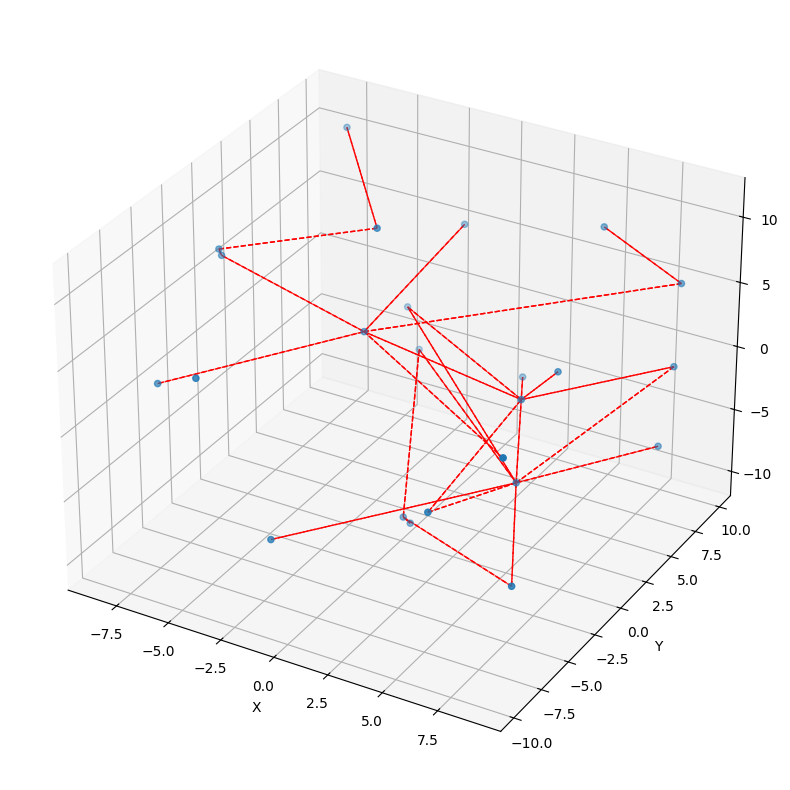

In [33]:
plot(3000)

# Graphs Neural Network

In [ ]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, split='train', transform=None):
         # Initialize the dataset with the root directory, split, and optional transform
        self.root = root
        self.split = split
        self.transform = transform
        self.graph_files = []

        classes = os.listdir(root) # Get the list of classes (subdirectories) in the root directory

        # Iterate through each class
        for class_folder in classes:
            class_path = os.path.join(root, class_folder)
            
            # Check if the class folder is a directory
            if os.path.isdir(class_path):
                # Create the path to the split folder (train, test, etc.) within the class folder
                split_folder = os.path.join(class_path, split)
                
                # Get the list of graph files (with the .gph extension) in the split folder
                graph_files = [os.path.join(split_folder, f) for f in os.listdir(split_folder) if f.endswith('.gph')]
                
                # Extend the list of graph files in the dataset with the current class's graph files
                self.graph_files.extend(graph_files)

    def __len__(self): # Return the total number of graph files in the dataset
        return len(self.graph_files)

    def __getitem__(self, idx):
        # Get the file path of the graph file at the specified index
        graph_file = self.graph_files[idx]
        
        # Load the graph data from the file using torch
        data = torch.load(graph_file)
        
        # Add ground truth label based on class (assuming class names in the file paths)
        class_label = None
        for i, class_name in enumerate(['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night', 'sofa', 'table', 'toilet']):
            if class_name in graph_file:
                class_label = i
                break

        # Check if class_label is still None, indicating an unknown class
        if class_label is None:
            raise ValueError(f"Unknown class for file: {graph_file}")

        # Set the ground truth label as a tensor in the 'y' attribute of the graph data
        data.y = torch.tensor([class_label], dtype=torch.long)

        # Apply the transform if provided
        if self.transform:
            data = self.transform(data)

        return data


# Load the graph data using the CustomGraphDataset
def load_graph_data(filepath):
    dataset = CustomGraphDataset(filepath, transform=Constant())
    return dataset

In [ ]:
# Define the Graph Neural Network model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        # Graph convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # Apply the third graph convolutional layer
        x = self.conv3(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = global_mean_pool(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

    def save_model(self, filepath):
        # Save the model's state_dict to the specified filepath
        torch.save(self.state_dict(), filepath)
        print(f'Model saved to {filepath}')

    def load_model(self, filepath):
        # Load the model's state_dict from the specified filepath
        self.load_state_dict(torch.load(filepath))
        print(f'Model loaded from {filepath}')

# Train the GNN model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = output.max(1)
        total_train += data.y.size(0)
        correct_train += predicted.eq(data.y).sum().item()

    accuracy_train = correct_train / total_train
    average_loss = total_loss / len(train_loader)
    return accuracy_train, average_loss

# Evaluate the GNN model
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_eval = 0
    total_eval = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)

            total_loss += loss.item()

            _, predicted = output.max(1)
            total_eval += data.y.size(0)
            correct_eval += predicted.eq(data.y).sum().item()

    accuracy_eval = correct_eval / total_eval
    average_loss = total_loss / len(loader)
    return accuracy_eval, average_loss

In [ ]:
# Function to plot training and testing results
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Plotting training loss and test loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training accuracy and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Main function to train and evaluate the GNN model
def main(root_path, lr=0.01, epochs=100, batch_size=64, plot_graphs=False):

    # Define the output path for saving the trained model
    output_path = 'Saved/' + root_path + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    output_path += 'lr' + str(lr) + 'bs' + str(batch_size) + '.pt'

    # Set device (use GPU if available)
    device = torch.device("cpu")

    # Create training and testing datasets
    train_dataset = CustomGraphDataset(root_path, split='train', transform=Constant())
    test_dataset = CustomGraphDataset(root_path, split='test', transform=Constant())

    # Define GNN model
    input_dim = 6
    hidden_dim = 64
    output_dim = 10
    model = GNNModel(input_dim, hidden_dim, output_dim).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr)
    criterion = nn.NLLLoss()

    # Prepare data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate the model before training and print initial results
    test_acc, test_loss = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {0}/{epochs} => '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Lists to store results for plotting
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Train the model and capture results
    for epoch in range(1, epochs + 1):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion, device)
        test_acc, test_loss = evaluate(model, test_loader, criterion, device)

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        if epoch % 5 == 0:
            print(f'Epoch {epoch}/{epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | '
                  f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Plotting the results if plot_graphs is True
    if plot_graphs:
        plot_results(train_losses, train_accuracies, test_losses, test_accuracies)

    # Save the trained model
    model.save_model(output_path)
    return model


In [ ]:
main('a25220000',lr=0.01, epochs=50, batch_size=16,plot_graphs=True)

c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/50 => Test Loss: 5.9901, Test Accuracy: 0.1198


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Genetic Algorithm Section

In [140]:
population_size = 10
mutation_rate = 0.2
tournament_size = 4
num_gens = 40
epochs = 20
Alpha = 0.1

parameters = {
    "distance": [2, 3, 5, 7, 10],
    "overlap": [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    "min_samples" : list(range(1,6)),
    "num_intervals": [5, 7, 10],  
    "argument": [0, 1, 2],
    "centroid": [True, False],
    "density": [True, False],
    "diameter": [True, False]
}

Encoding = ["distance", "overlap", "num_intervals", "argument", "min_samples", "centroid", "density", "diameter"]
Range_of_parameters = [len(parameters[y]) for y in Encoding]

def generate_population(n, m = len(parameters)):
    permutations_list = []
    while len(permutations_list) < n:
        permutation = []
        for i in range(m):
            permutation.append(random.choice(range(Range_of_parameters[i])))
        if permutation not in permutations_list:
            permutations_list.append(permutation)
    return permutations_list


best = [2, 5, 2, 2, 0, 0, 0, 0]

population = [[2, 5, 2, 2, 0, 0, 0, 0],
              [1, 5, 0, 2, 4, 1, 0, 1],
              [2, 0, 1, 1, 4, 1, 1, 1],
              [2, 0, 2, 1, 4, 1, 0, 1],
              [2, 0, 2, 1, 0, 1, 0, 1],
              [0, 4, 0, 1, 1, 1, 1, 0],
              [2, 4, 1, 1, 2, 0, 1, 1],
              [3, 7, 0, 1, 0, 1, 0, 1],
              [0, 3, 2, 0, 3, 0, 1, 1],
              [2, 2, 1, 0, 0, 1, 1, 0]]


In [141]:
def person_to_graph(person, indexes):
    path = 'a' + numbers_to_string(person)
    if Memo.get(path):
        
        return Memo[path]
    
    distance = parameters[Encoding[0]][person[0]]
    overlap = parameters[Encoding[1]][person[1]]
    num_intervals = parameters[Encoding[2]][person[2]]
    argument = parameters[Encoding[3]][person[3]]
    
    min_samples = parameters[Encoding[4]][person[4]]
    include_centroid = parameters[Encoding[5]][person[5]]
    include_density = parameters[Encoding[6]][person[6]] 
    include_diameter = parameters[Encoding[7]][person[7]]

    eps = 1.1 * distance

    points_list = [distance]

    points_path = 'points' + '/' + 'a' + numbers_to_string(points_list) + '/'

    cluster_list = [distance, overlap, argument, num_intervals, min_samples]
    
    cluster_path = 'clusters' + '/' + 'a' + numbers_to_string(cluster_list) + '/'
    
    for index in indexes:
        try:
            data = df[index] # Extract data based on the given index
            file_path = 'ModelNet10/' + data[-1] # Construct the file path based on the data
            points_instance_path = points_path +  data[1] + '/' + data[2] + '/' + data[0] + '.pkl'
            cluster_instance_path = cluster_path +  data[1] + '/' + data[2] + '/' + data[0] + '.pkl'
            i_path = path + '/'
            graph_path = i_path + data[1] + '/' + data[2] + '/' + data[0] + '.gph'
            G = None
            if index not in bad_files_indexes:
                try:
                    if os.path.exists(graph_path):
                        G = torch.load(graph_path)
                    else:
                        
                        # Attempt to convert the current index into a graph
                        Clusters = load_list(cluster_instance_path)
                        vertices = load_list(points_instance_path)
                        
                        if len(Clusters) == 0:
                            if len(vertices) == 0:   
                                vertices = path_to_points(file_path, distance)
                                # Read points from the specified path
                                if len(vertices) > 500000:
                                    print(f"# of vertices: {len(vertices)}")
                                    raise ValueError("Too many vertices")
                                save_list(vertices, points_instance_path)
                            Clusters = cluster_func(vertices, argument, num_intervals, overlap, eps=eps, min_samples=min_samples) # Perform clustering on the vertices
                            if len(Clusters) > 6000:
                                    print(f"# of Clusters: {len(Clusters)}")
                                    raise ValueError("Too many clusters")
                            save_list(Clusters, cluster_instance_path)
                        G = cluster_to_graph(vertices, Clusters, include_centroid=include_centroid, include_diameter = include_diameter, include_density = include_density) # Convert clusters to a graph
                        os.makedirs(os.path.dirname(graph_path), exist_ok=True)
                        torch.save(G, graph_path)
                    print(f'Index: {index}, {data[0]} Converted')
                except ValueError as e:
                    bad_files_indexes.append(index)
                    # Handle the case where the conversion to a graph failed due to a ValueError
                    print(f"Couldn't convert {data[0]} into a graph because of {e}.")

                except FileNotFoundError as e:
                    bad_files_indexes.append(index)
                    # Handle the case where the file required for conversion is not found
                    print(f"Couldn't convert {data[0]} because the file is not found.")

                except MemoryError as e:
                    bad_files_indexes.append(index)
                    # Handle the case where a MemoryError occurs during the conversion
                    print(f"Couldn't convert {data[0]} due to Memory Error")
        except TypeError as e:
                bad_files_indexes.append(index)
                # Handle the case where a MemoryError occurs during the conversion
                print(f"Couldn't convert {data[0]} due to Memory Error")
    return G

In [13]:
person_to_graph(best, list(range(0, 4902)))

Index: 0, bathtub_0107 Converted
Index: 1, bathtub_0108 Converted
Index: 2, bathtub_0109 Converted
Index: 3, bathtub_0110 Converted
Index: 4, bathtub_0111 Converted
Index: 5, bathtub_0112 Converted
Index: 6, bathtub_0113 Converted
Index: 7, bathtub_0114 Converted
Index: 8, bathtub_0115 Converted
Index: 9, bathtub_0116 Converted
Index: 10, bathtub_0117 Converted
Index: 11, bathtub_0118 Converted
Index: 12, bathtub_0119 Converted
Index: 13, bathtub_0120 Converted
Index: 14, bathtub_0121 Converted
Index: 15, bathtub_0122 Converted
Index: 16, bathtub_0123 Converted
Index: 17, bathtub_0124 Converted
Index: 18, bathtub_0125 Converted
Index: 19, bathtub_0126 Converted
Index: 20, bathtub_0127 Converted
Index: 21, bathtub_0128 Converted
Index: 22, bathtub_0129 Converted
Index: 23, bathtub_0130 Converted
Index: 24, bathtub_0131 Converted
Index: 25, bathtub_0132 Converted
Index: 26, bathtub_0133 Converted
Index: 27, bathtub_0134 Converted
Index: 28, bathtub_0135 Converted
Index: 29, bathtub_0136 

TypeError: can only concatenate str (not "float") to str

In [41]:
person_to_graph(best, list(range(4456, 4902)))

Couldn't convert nan due to Memory Error
Index: 4457, toilet_0345 Converted
Index: 4458, toilet_0346 Converted
Index: 4459, toilet_0347 Converted
Index: 4460, toilet_0348 Converted
Index: 4461, toilet_0349 Converted
Index: 4462, toilet_0350 Converted
Index: 4463, toilet_0351 Converted
Index: 4464, toilet_0352 Converted
Index: 4465, toilet_0353 Converted
Index: 4466, toilet_0354 Converted
Index: 4467, toilet_0355 Converted
Index: 4468, toilet_0356 Converted
Index: 4469, toilet_0357 Converted
Index: 4470, toilet_0358 Converted
Index: 4471, toilet_0359 Converted
Index: 4472, toilet_0360 Converted
Index: 4473, toilet_0361 Converted
Index: 4474, toilet_0362 Converted
Index: 4475, toilet_0363 Converted
Index: 4476, toilet_0364 Converted
Index: 4477, toilet_0365 Converted
Index: 4478, toilet_0366 Converted
Index: 4479, toilet_0367 Converted
Index: 4480, toilet_0368 Converted
Index: 4481, toilet_0369 Converted
Index: 4482, toilet_0370 Converted
Index: 4483, toilet_0371 Converted
Index: 4484, t

Data(x=[22, 5], edge_index=[2, 32])